## Developing a Classifier for the problem

___
___


### Approach 1: 

- take total deposition in ml/m²
- thresholding: self defined constant
- train Whole Image CLFs
- train P2P CLfs

evaluate;

Threshold calculation:

Injection mass is 0.095kg; total area is 6*2 = 12m²;    
hence ~ 95/12 ml/m² = 7.91 ml/m² at uniform coverage;   
at 600 cells, this gives 0.0131 ml/cell - which is the threshold value


In [1]:
import os
import numpy as np

# general run param definition
steadystate_time = 18

total_dir = "/home/sam/Documents/openfoam-spray-runs/Output_numpys/total"
home_dir = "/home/sam/Documents/openfoam-spray-runs/exploratory_ML/DK_jup"

# get list of all numpys
os.chdir(total_dir)
np_sets = [".".join(f.split(".")[:-1]) for f in os.listdir() if os.path.isfile(f)]

# define threshold
thresh = 0.0131 * 10**-3

# iterate over all np_sets, import and threshold, flatten them, catenate into one array and 
# extract the input params from the name:

for idx, dataframe in enumerate(np_sets):
    
    df = np.load( (dataframe + '.npy') )
    df = df[:,:,steadystate_time]
    df_th = df > thresh
    
    nms = dataframe.split('_')
    run_params = np.array([nms[1], nms[2], nms[3], nms[4], nms[5]], 'f')
    
    if idx == 0:
        inputs = run_params
        out_th = df_th
        out_th_f = df_th.flatten()
        outputs = df

    else:
        inputs = np.vstack((run_params, inputs))
        out_th = np.dstack((out_th, df_th))
        out_th_f = np.vstack((out_th_f, df_th.flatten()))
        outputs = np.dstack((outputs, df))
        
os.chdir(home_dir)

out_th = np.swapaxes(out_th, 0, 2)
out_th = np.swapaxes(out_th, 1, 2)

print('input shape:', np.shape(inputs))
print('output shape:', np.shape(out_th))


input shape: (3763, 5)
output shape: (3763, 30, 20)




scale the input variables, test/train splitting on flattened array:

In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
inputs = scaler.fit_transform(inputs)


In [3]:
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(range(len(np_sets)), 
                                       train_size = 0.9,
                                       shuffle = True)

X_train = inputs[idx_train, :] * 1     # the lazy way of 0/1 encoding
X_test = inputs[idx_test, :] * 1
Y_train = out_th_f[idx_train, :] * 1
Y_test = out_th_f[idx_test, :] * 1


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import random

def check_classifier(y_test, y_pred, probs):
    fpr, tpr, _ = roc_curve(y_test, probs[:,1])
    roc_auc = roc_auc_score(y_test, probs[:,1])

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    conf_arr = np.array([[tp, fn],[fp,tn,]])
    conf_arr = conf_arr / conf_arr.sum() * 100
    cm = pd.DataFrame(conf_arr, index = [ 'True H', 'True A'], columns = ['Predicted H', 'Predicted A'])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
    ax1.plot(fpr, tpr, 'b', label='ROC curve (area = %0.2f)' % roc_auc)
    ax1.plot(fpr, fpr, 'k-')
    ax1.legend()
    sns.heatmap(cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f',  ax = ax2)
    ax2.set_xlabel("Predictions")
    ax2.set_ylabel("True Test Values")
    ax1.set_xlabel("true positive rate")
    ax1.set_ylabel("false positive rate")
    print('true positive', tp, 'true negative', tn)
    print('false positve', fp, 'false negative', fn)
    print('Accuracy: %0.2f' % ((tp+tn)/(tp+tn+fp+fn)))
    print('AUC: %0.2f' % roc_auc)
    
    return
 
def plot_pred(CLF):
    views = random.choices(idx_test, k = 10)
    pred = CLF.predict(inputs[views, :])

    fig, ax = plt.subplots(2,10, figsize = (18,6))
    
    for idx, case in enumerate(views):
        ax[0, idx].imshow(out_th[idx, :, :], clim = (0,1), cmap = 'hot')
        ax[1, idx].imshow(pred[idx, :].reshape(30,20), clim = (0,1), cmap = 'hot')
        ax[1, idx].get_xaxis().set_visible(False)
        ax[1, idx].get_yaxis().set_visible(False)
        ax[0, idx].get_xaxis().set_visible(False)
        ax[0, idx].get_yaxis().set_visible(False)

    return


#### Classification Approach 1

1 - MLP

600 P2P Classifier MLPs


mean accuracy 0.7796993810786913
sd accuracy 0.16984153072635735
false positive rate 0.13345558316216316


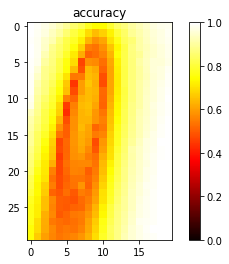

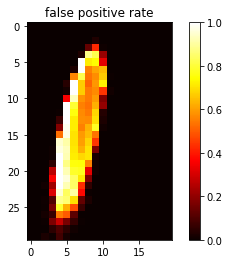

In [5]:
from sklearn.neural_network import MLPClassifier

accuracy = np.zeros((600))
fp_rate = np.zeros((600))

for i in range(600):
        MLP = MLPClassifier(activation = 'tanh', 
                   hidden_layer_sizes = (25, 25),
                   max_iter = 600,
                   tol = 10**-3).fit(X_train, Y_train[:,i])

        pred = MLP.predict(X_test)
        probs = MLP.predict_proba(X_test)
        tn, fp, fn, tp = confusion_matrix(Y_test[:,i], pred,labels=[0,1]).ravel()
        ac = (tp + tn) / (tp+tn+fp+fn)
        fp_r = fp / (tn + tp)
        accuracy[i] = ac
        fp_rate[i] = fp_r
        
acc = accuracy.reshape(30,20)
fp_r = fp_rate.reshape(30,20)

plt.imshow(acc, cmap = 'hot')
plt.title('accuracy')
plt.clim(0,1)
plt.colorbar()


plt.figure()
plt.imshow(fp_r, cmap = 'hot')
plt.title('false positive rate')
plt.clim(0,1)
plt.colorbar()


print('mean accuracy', np.mean(acc))
print('sd accuracy', np.std(acc))
print('false positive rate', np.mean(fp_rate))

this one looks best: 3150


mean accuracy 0.7791865605658709
sd accuracy 0.17058842933600304
false positive rate 0.1331547211392416


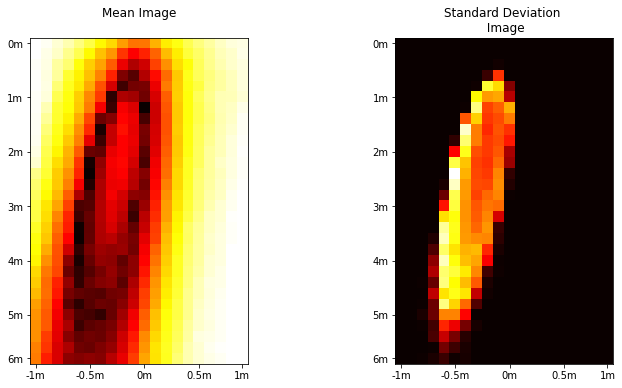

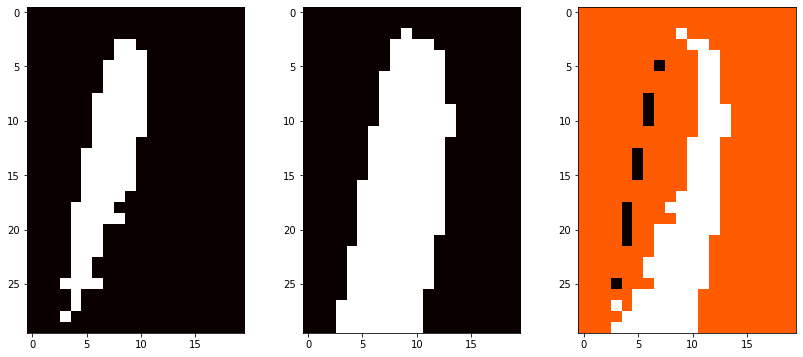

In [6]:
#img = random.choices(idx_test, k = 1)

img = 3150
X_p = inputs[img, :]
Y_t = out_th_f[img,:]

preds = np.zeros((600))

for i in range(600):
        MLP = MLPClassifier(activation = 'tanh', 
                   hidden_layer_sizes = (25, 25),
                   max_iter = 600,
                   tol = 10**-3).fit(X_train, Y_train[:,i])

        p = MLP.predict(X_p.reshape(1, -1))
        preds[i] = p
        
        pred = MLP.predict(X_test)
        probs = MLP.predict_proba(X_test)
        tn, fp, fn, tp = confusion_matrix(Y_test[:,i], pred,labels=[0,1]).ravel()
        ac = (tp + tn) / (tp+tn+fp+fn)
        fp_r = fp / (tn + tp)
        accuracy[i] = ac
        fp_rate[i] = fp_r
        
acc = accuracy.reshape(30,20)
fp_r = fp_rate.reshape(30,20)

fig, ax = plt.subplots(1,2, figsize=(12,6))
m = ax[0].imshow(acc * 100, cmap='hot')
ax[0].set_title('Mean Image\n')
s = ax[1].imshow(fp_r*100, cmap='hot')
ax[1].set_title('Standard Deviation \n Image')

ax[0].set_xticks([0, 5, 10, 15, 19])
ax[0].set_xticklabels(['-1m', '-0.5m', '0m', '0.5m', '1m'])
ax[1].set_xticks([0, 5, 10, 15, 19])
ax[1].set_xticklabels(['-1m', '-0.5m', '0m', '0.5m', '1m'])
ax[0].set_yticks([0, 5, 10, 15, 20, 25, 29])
ax[0].set_yticklabels(['0m','1m', '2m', '3m', '4m', '5m', '6m'])
ax[1].set_yticks([0, 5, 10, 15, 20, 25, 29])
ax[1].set_yticklabels(['0m','1m', '2m', '3m', '4m', '5m', '6m'])

print('mean accuracy', np.mean(acc))
print('sd accuracy', np.std(acc))
print('false positive rate', np.mean(fp_rate))

fig, ax = plt.subplots(1,3, figsize=(14,6))
ax[0].imshow(preds.reshape(30,20), cmap = 'hot')
ax[1].imshow(Y_t.reshape(30,20), cmap = 'hot')
ax[2].imshow((Y_t-preds).reshape(30,20), cmap = 'hot')


[Text(0, 0, '0m'),
 Text(0, 0, '1m'),
 Text(0, 0, '2m'),
 Text(0, 0, '3m'),
 Text(0, 0, '4m'),
 Text(0, 0, '5m'),
 Text(0, 0, '6m')]

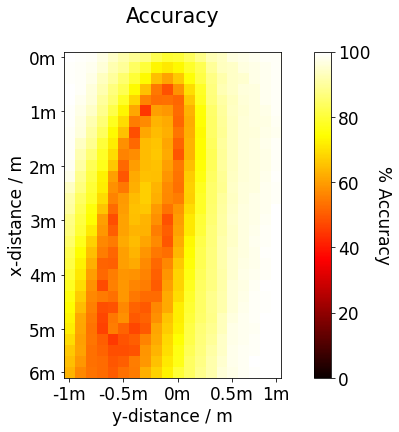

In [8]:
acc = accuracy.reshape(30,20)
fp_r = fp_rate.reshape(30,20)

plt.rcParams.update({'font.size': 17})

fig, ax = plt.subplots(1,1, figsize=(12,6))
m = ax.imshow(acc * 100, cmap='hot', clim = (0,100))
ax.set_title('Accuracy\n')
ax.set_xlabel('y-distance / m')
ax.set_ylabel('x-distance / m')
cbar = plt.colorbar(m, ax=ax, shrink = 1)
cbar.set_label('% Accuracy', rotation = -90, va = 'bottom')
ax.set_xticks([0, 5, 10, 15, 19])
ax.set_xticklabels(['-1m', '-0.5m', '0m', '0.5m', '1m'])
ax.set_yticks([0, 5, 10, 15, 20, 25, 29])
ax.set_yticklabels(['0m','1m', '2m', '3m', '4m', '5m', '6m'])


[Text(0, 0, '0m'),
 Text(0, 0, '1m'),
 Text(0, 0, '2m'),
 Text(0, 0, '3m'),
 Text(0, 0, '4m'),
 Text(0, 0, '5m'),
 Text(0, 0, '6m')]

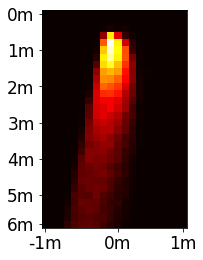

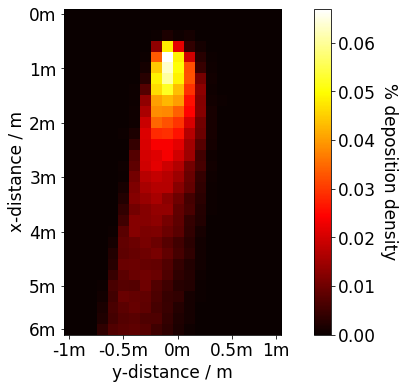

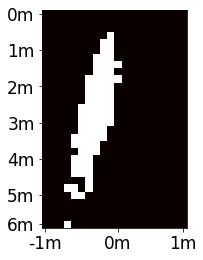

In [9]:
import matplotlib.pyplot as plt
img = 3150

fig, ax = plt.subplots()
ax.imshow(outputs[:,:, img], cmap = 'hot')
ax.set_xticks([0, 10, 19])
ax.set_xticklabels(['-1m', '0m', '1m'])
ax.set_yticks([0, 5, 10, 15, 20, 25, 29])
ax.set_yticklabels(['0m','1m', '2m', '3m', '4m', '5m', '6m'])

fig, ax = plt.subplots(1,1, figsize=(12,6))
m = ax.imshow(outputs[:,:, img]*100, cmap='hot')
ax.set_xlabel('y-distance / m')
ax.set_ylabel('x-distance / m')
cbar = plt.colorbar(m, ax=ax, shrink = 1)
cbar.set_label('% deposition density', rotation = -90, va = 'bottom')
ax.set_xticks([0, 5, 10, 15, 19])
ax.set_xticklabels(['-1m', '-0.5m', '0m', '0.5m', '1m'])
ax.set_yticks([0, 5, 10, 15, 20, 25, 29])
ax.set_yticklabels(['0m','1m', '2m', '3m', '4m', '5m', '6m'])


fig, ax = plt.subplots()
ax.imshow(preds.reshape(30,20), cmap = 'hot')
ax.set_xticks([0, 10, 19])
ax.set_xticklabels(['-1m', '0m', '1m'])
ax.set_yticks([0, 5, 10, 15, 20, 25, 29])
ax.set_yticklabels(['0m','1m', '2m', '3m', '4m', '5m', '6m'])

mean accuracy 0.7820159151193635
sd accuracy 0.1731956210896708
false positive rate 0.11605490012274716


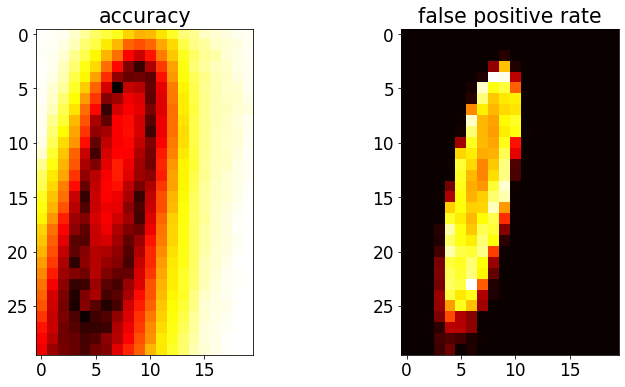

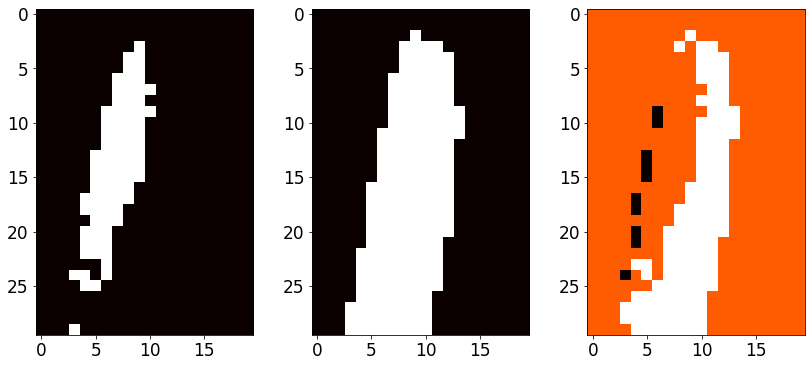

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].imshow(acc, cmap = 'hot')
ax[0].set_title('accuracy')

ax[1].imshow(fp_r, cmap = 'hot')
ax[1].set_title('false positive rate')


print('mean accuracy', np.mean(acc))
print('sd accuracy', np.std(acc))
print('false positive rate', np.mean(fp_rate))

fig, ax = plt.subplots(1,3, figsize=(14,6))
ax[0].imshow(preds.reshape(30,20), cmap = 'hot')
ax[1].imshow(Y_t.reshape(30,20), cmap = 'hot')
ax[2].imshow((Y_t-preds).reshape(30,20), cmap = 'hot')
